In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import time 
from ymaeda_tools.dft import dft, idft, timeshift_cplx, halfdft_timeshift, exidft_timeshift, exidft_cplx_timeshift
from ymaeda_tools.read_dGM import read_dseq1, read_dimseq2, readall_dobs

# This Jupyter notebook handles the various checks on the DFT (discrete Fourier transform) algorithms 
# used in YMAEDA_TOOLS.

# time step used by YMAEDA_TOOLS
dt = 0.1 
# frequency step size used by YMAEDA_TOOLS
df = 0.002441406 
# frequency half space used by YMAEDA_TOOLS
f = np.arange(0, df * 2049, df) 
# frequency full space used by YMAEDA_TOOLS
F = np.arange(0, df * 4096, df) 

# base and parent directories
base_dir = "/Users/ynatsume/jupyter_main/Shinmoedake Data/"
parent_dir = "inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

# target directory
target_dir = "inv_data_dir_supershort_filtered/"

# wanted station
station = "EV.SMN"

In [19]:
def load_seq1(directory_name):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = ".E.sac.M.seq1"
        N_suffix = ".N.sac.M.seq1"
        U_suffix = ".U.sac.M.seq1"
    else:
        E_suffix = ".E.sac.seq1"
        N_suffix = ".N.sac.seq1"
        U_suffix = ".U.sac.seq1"
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    E = read_dseq1(directory_name, station + E_suffix)
    N = read_dseq1(directory_name, station + N_suffix)
    U = read_dseq1(directory_name, station + U_suffix)
    
    t = np.arange(0, len(E) * dt, dt)
    return t, E, N, U
    
def load_imseq2(directory_name):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = '.E.sac.M.imseq2'
        N_suffix = '.N.sac.M.imseq2'
        U_suffix = '.U.sac.M.imseq2'
    else:
        E_suffix = '.E.sac.imseq2'
        N_suffix = '.N.sac.imseq2'
        U_suffix = '.U.sac.imseq2'
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    f_E, C_E = read_dimseq2(directory_name, station + E_suffix)
    f_N, C_N = read_dimseq2(directory_name, station + N_suffix)
    f_U, C_U = read_dimseq2(directory_name, station + U_suffix)
    return f_U, C_E, C_N, C_U

(61,) (61,) (61,) (61,)
(4096,) (4096,) (4096,) (4096,)


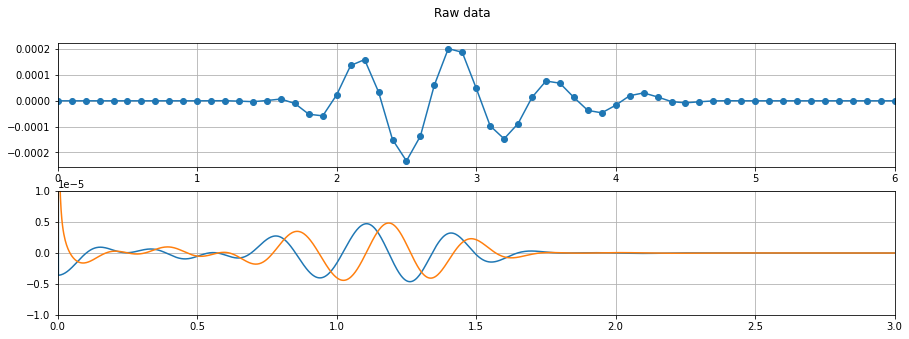

In [20]:
# Raw measured seismograms .seq1 files in the level above the inversion base directory

raw_dat_dir = \
"inversion_result_residuals117/data_obs/inv_data_dir_supershort_filtered/"

raw_E = read_dseq1(base_dir + raw_dat_dir, "EV.SMN.E.sac.seq1")
raw_N = read_dseq1(base_dir + raw_dat_dir, "EV.SMN.N.sac.seq1")
raw_U = read_dseq1(base_dir + raw_dat_dir, "EV.SMN.U.sac.seq1")
raw_t = np.arange(0, len(raw_E) * dt, dt)

# Raw measured full spectrum seismograms spectrum .imseq2 files in the level above the inversion base directory

raw_dat_dir = \
"inversion_result_residuals117/data_obs_spectrum/inv_data_dir_supershort_filtered/"

f_raw_E_spec, raw_E_spec = read_dimseq2(base_dir + raw_dat_dir, "EV.SMN.E.sac.imseq2")
f_raw_N_spec,raw_N_spec = read_dimseq2(base_dir + raw_dat_dir, "EV.SMN.N.sac.imseq2")
f_raw_U_spec, raw_U_spec = read_dimseq2(base_dir + raw_dat_dir, "EV.SMN.U.sac.imseq2")

print(raw_t.shape, raw_E.shape, raw_N.shape, raw_U.shape)
print(np.shape(f_raw_E_spec), np.shape(raw_E_spec), np.shape(raw_N_spec), np.shape(raw_U_spec))

plt.figure(figsize = (15, 5))
plt.suptitle("Raw data")
plt.subplot(2, 1, 1)
plt.plot(raw_t, raw_U, "-o")
plt.xlim([0, 6])
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(f_raw_U_spec, np.real(raw_U_spec))
plt.plot(f_raw_U_spec, np.imag(raw_U_spec))
plt.grid(True)
plt.xlim([0, 3.0])
plt.ylim(-1e-5, 1e-5)
plt.show()

(4096,) (4096,)


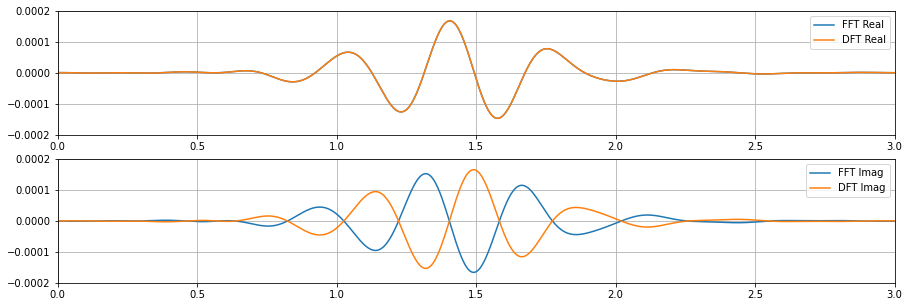

In [16]:
# Also, note the difference between "standard" FFT algorithms and YMAEDA_TOOLS DFT.
# While the real portion is the same, the imaginary portion is not!

# Don't forget to zero-pad to length of 4096 to ensure compatibility with YMAEDA_TOOLS...
CU = fft(np.hstack([raw_U, np.zeros(4096 - len(raw_U))])) * dt # scipy FFT
CU1 = dft(np.hstack([raw_U, np.zeros(4096 - len(raw_U))])) * dt # YMAEDA_TOOLS compliant DFT

print(CU.shape, CU1.shape)

plt.figure(figsize = (15, 5))
plt.subplot(2, 1, 1)
plt.plot(f_raw_U_spec, np.real(CU), f_raw_U_spec, np.real(CU1))
plt.xlim([0, 3])
plt.ylim([-2e-4, 2e-4])
plt.legend(["FFT Real", "DFT Real"])
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(f_raw_U_spec, np.imag(CU), f_raw_U_spec, np.imag(CU1))
plt.xlim([0, 3])
plt.ylim([-2e-4, 2e-4])
plt.legend(["FFT Imag", "DFT Imag"])
plt.grid(True)
plt.show()

(4096,) (4096,) (4096,) (4096,)
(4096,) (4096,) (4096,) (4096,)


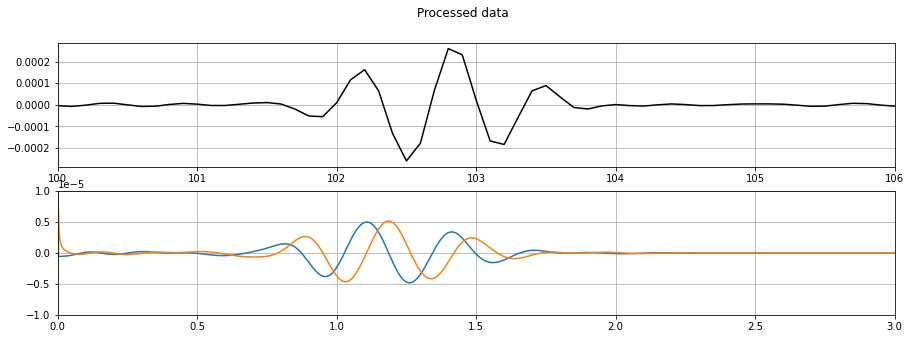

In [5]:
# YMAEDA_TOOLS data_syn/ processed seismograms and spectra
# This waveform and spectrum are not the original observed seismograms, but have been processed for inversion.

t, E, N, U = load_seq1("data_syn/")
f_U, C_E, C_N, C_U = load_imseq2("data_syn_spectrum/")

print(t.shape, E.shape, N.shape, U.shape)
print(f_U.shape, C_E.shape, C_N.shape, C_U.shape)

# Check if the DFT of data_syn/X.seq1 matches data_syn_spectrum/X.imseq2...
#U_spec = dft(U) * dt

# Check if the IDFT of data_syn_spectrum/X.imseq2 matches data_syn/X.seq1...
#C_U_t = np.real(idft(timeshift_cplx(C_U))) / dt

plt.figure(figsize = (15, 5))
plt.suptitle("Processed data")
plt.subplot(2,1,1)
plt.xlim([100, 106])
plt.plot(t, U, "k")
#plt.plot(t, C_U_t, "r")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(f_U, np.real(C_U), f_U, np.imag(C_U))
#plt.plot(f_U, np.real(U_spec), f_U, np.imag(U_spec))
plt.xlim([0, 3.0])
plt.ylim(-1e-5, 1e-5)
plt.grid(True)
plt.show()